In [15]:
import os
import math
import locale
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [24]:
# Set the font settings
locale.setlocale(locale.LC_NUMERIC, "de_DE")
plt.rcParams['axes.formatter.use_locale'] = True

font = {'family' : 'Times New Roman',
        'weight' : 'regular',
        'size'   : 18}

matplotlib.rc('font', **font)

In [25]:
def get_conus(n, m, R, H, Kx, Ky):
    res = np.zeros(shape=(n, m))
    
    for i in range(n):
        for j in range(m):
            res[i, j] = 1000 * H * (1 - (np.sqrt(((Kx * (i - n/2))** 2 + (Ky * (j - m/2))** 2) / (R**2))))
            p = np.sqrt((i - n/2)**2 + (j - m/2)**2)
            
            if p > R / Kx:
                res[i, j] = 0
            if p > R / Ky:
                res[i, j] = 0
    return res

In [26]:
def get_sphere(n, m, R, Kx, Ky):
    res = np.zeros(shape=(n, m))
    
    for i in range(n):
        for j in range(m):
            res[i, j] = 1000 * np.sqrt(R**2 - (Kx*(i-n/2))**2 - (Ky*(j-n/2))**2)

    res[np.where(np.isnan(res)==True)] = 0
    return res

In [27]:
def interferogramma(n, m, z, a, b, dzr, Lcoh, lamda0):
    # Константы для амплитуд
    As = 1
    Ar = 1

    # Инициализация матрицы для хранения интерферограммы
    I2D1 = np.zeros((n, m))

    # Проход по всем пикселям в сетке n x m
    for x in range(n):
        for y in range(m):
            # Расчёт расстояний для объекта и эталона
            ds = 2 * z[x, y]                   # Расстояние до объекта
            dr = a * y + b * x + 2 * dzr       # Расстояние до эталона

            # Расчёт фазовых разностей
            dfs = (2 * np.pi / lamda0) * ds    # Фаза для объекта
            dfr = (2 * np.pi / lamda0) * dr    # Фаза для эталона

            # Расчёт коэффициента когерентности
            G = np.exp(-1 * (ds - dr)**2 / (Lcoh**2))

            # Расчёт интенсивности в каждой точке интерферограммы
            I2D1[x, y] = As**2 + Ar**2 + 2 * As * Ar * G * np.cos(dfr + dfs)

    return I2D1

In [28]:
Kx = 0.058594
Ky = 0.058594
n = 256
m = 256
yscanum = 12
xscanum = 12

n1 = 1.53
n0 = 1.55
R = 7.5
H = 9.5
Lcoh = 2300000
lamda0 = 610
k = yscanum / n
a = 0
b = 81
dzr = 0

ty = np.linspace(0, yscanum, n);
tx = np.linspace(0, xscanum, m);

In [29]:
sphere = (n0 - n1) * 2 * get_sphere(n, m, R, Kx, Ky)
cone = (n0 - n1) * 2 * get_conus(n, m, R, H, Kx, Ky)

C:\Users\Danis Garipov\AppData\Local\Temp\ipykernel_18904\3310516600.py:6: RuntimeWarning: invalid value encountered in sqrt
  res[i, j] = 1000 * np.sqrt(R**2 - (Kx*(i-n/2))**2 - (Ky*(j-n/2))**2)


In [30]:
obj = sphere
interf = interferogramma(n, m, obj, a, b, dzr, Lcoh, lamda0)

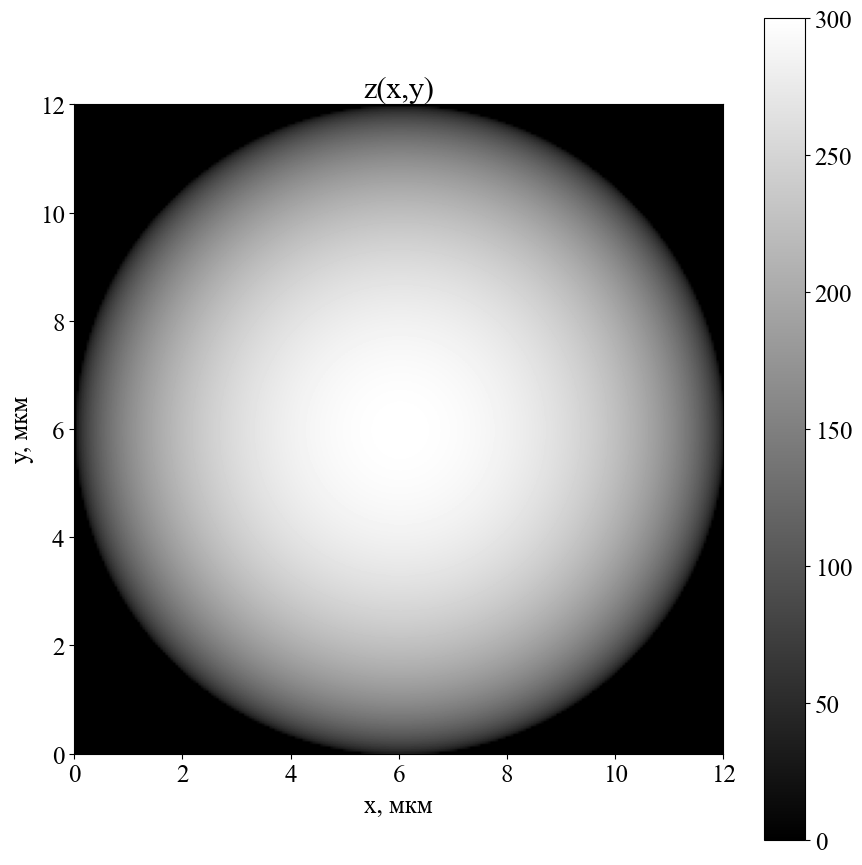

In [38]:
fig, ax = plt.subplots(figsize=(9, 9))
plt.imshow(obj, extent=(ty.min(), ty.max(), tx.min(), tx.max()), cmap='gray')
plt.colorbar();
plt.title('z(x,y)')
fig.tight_layout()
plt.xlabel('x, мкм')
plt.ylabel('y, мкм')
plt.savefig('..\Image\Сфера.jpeg', dpi=500)

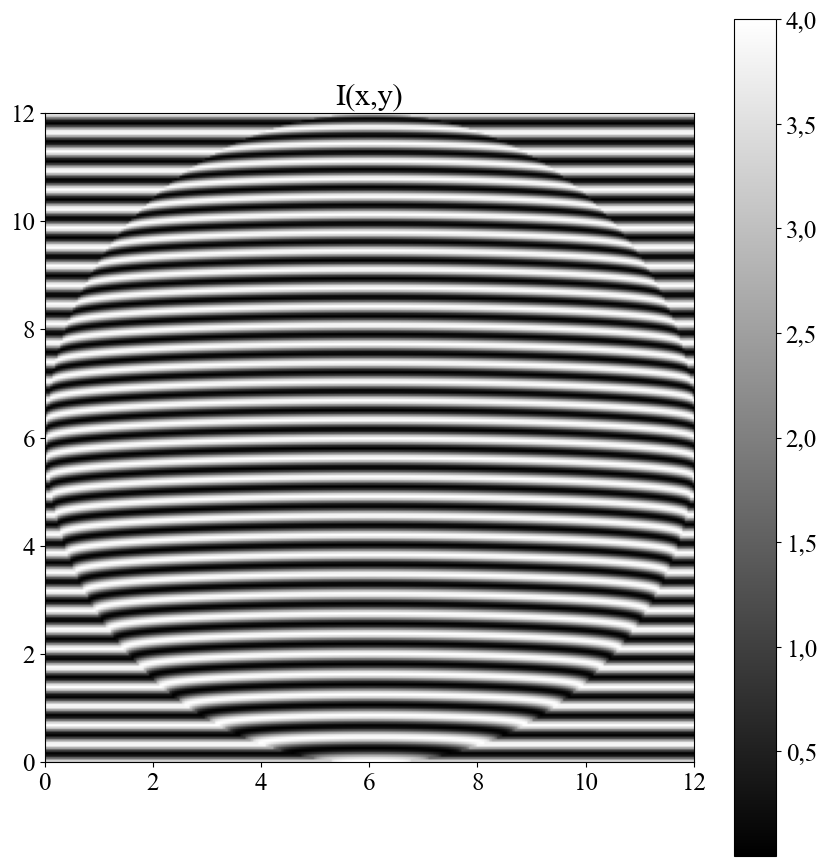

In [41]:
fig, ax = plt.subplots(figsize=(9, 9))
plt.imshow(interf, extent=(ty.min(), ty.max(), tx.min(), tx.max()), cmap='gray')
plt.colorbar();
plt.title('I(x,y)')
fig.tight_layout()
plt.savefig('..\Image\Интерферограмма.jpeg', dpi=500)

In [32]:
complex_spectrum = np.fft.fft2(interf)
complex_spectrum = np.fft.fftshift(complex_spectrum)

In [33]:
amplitude = np.abs(complex_spectrum)**(1/3)
# phase = np.arctan2(np.imag(complex_spectrum), np.real(complex_spectrum))

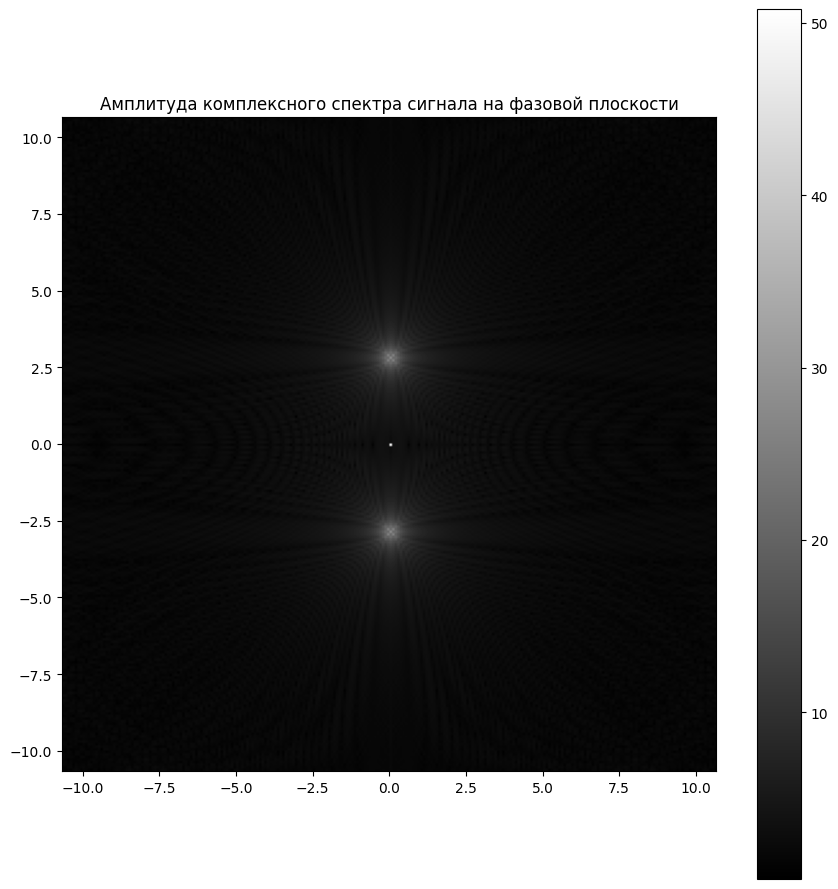

In [34]:
fy = np.linspace(-(1/(yscanum/n))/2, (1/(yscanum/n))/2, n)
fx = np.linspace(-(1/(xscanum/m))/2, (1/(xscanum/m))/2, m)
fig, ax = plt.subplots(figsize=(9, 9))
ax = plt.imshow(amplitude, cmap='gray', extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.colorbar();
# plt.title('Амплитуда комплексного спектра сигнала на фазовой плоскости')
fig.tight_layout()
# plt.savefig('Амплитуда комплексного спектра сигнала на фазовой плоскости.jpeg', dpi=500)

In [35]:
pad = 25
x0, y0 = n // 2 + 34, m // 2 + 0
complex_spectrum_cut = np.zeros_like(complex_spectrum[x0-pad:x0+pad, y0-pad:y0+pad], dtype=complex)
complex_spectrum_cut = complex_spectrum[x0-pad:x0+pad, y0-pad:y0+pad]
complex_spectrum_cut = np.pad(complex_spectrum_cut, n//2-pad, constant_values=(0+0j))
amplitude_cut = np.abs(complex_spectrum_cut)**(1/3)

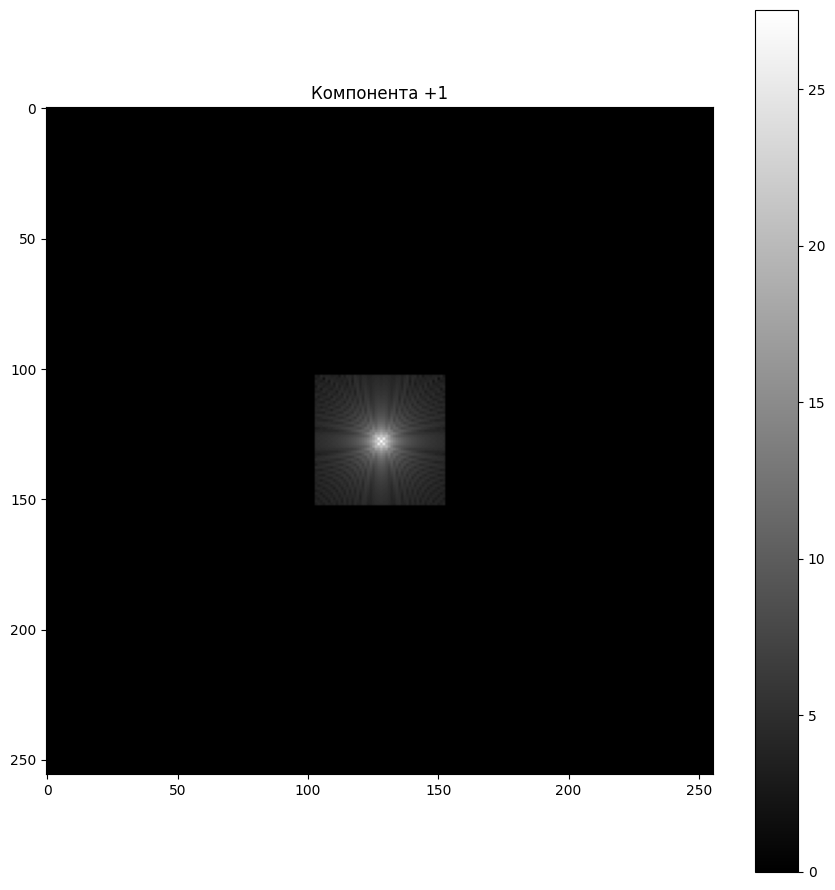

In [36]:
fig, ax = plt.subplots(figsize=(9, 9))
ax = plt.imshow(amplitude_cut, cmap='gray')
plt.colorbar();
plt.title('Компонента +1')
fig.tight_layout()
# plt.savefig('Компонента +1 на фазовой плоскости.jpeg', dpi=500)

In [37]:
complex_spectrum_cut = np.fft.ifftshift(complex_spectrum_cut)
wave_front = np.fft.ifft2(complex_spectrum_cut)

# свернутая фаза (фазовая развертка)
phase = np.angle(wave_front)
phase_ = phase - np.min(phase)

# Развёртка фазы
phase_unwraped = np.unwrap(phase_, axis=0)

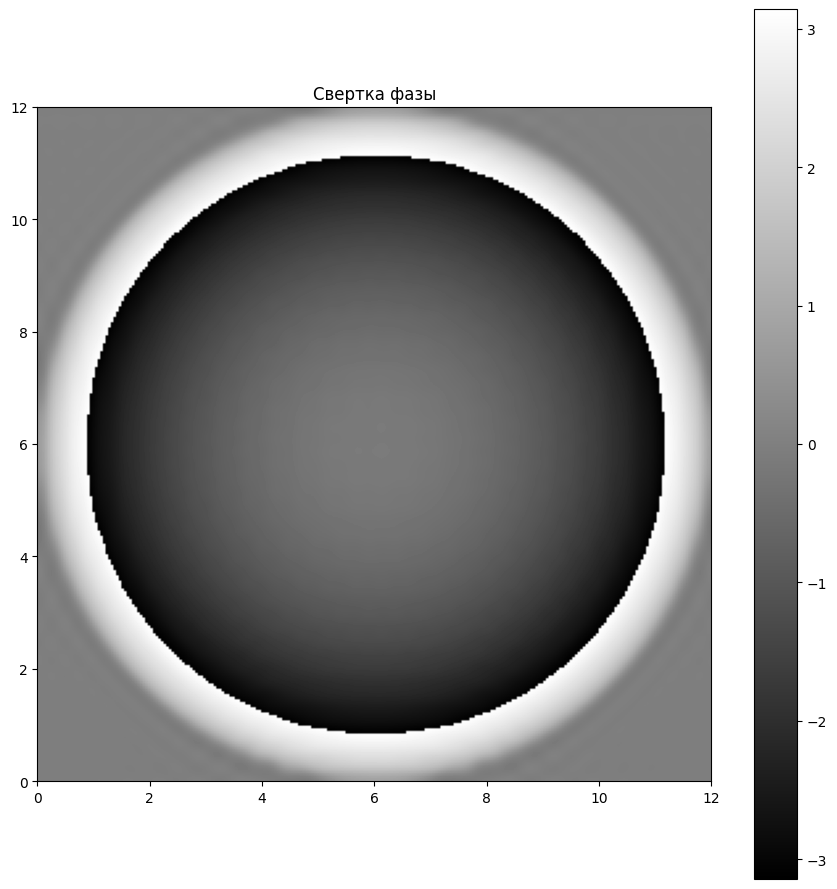

In [38]:
fig, ax = plt.subplots(figsize=(9, 9))
ax = plt.imshow(phase, cmap='gray', extent=[tx.min(), tx.max(), ty.min(), ty.max()])
plt.colorbar();
plt.title('Свертка фазы')
fig.tight_layout()
# plt.savefig('Свертка фазы.jpeg', dpi=500)

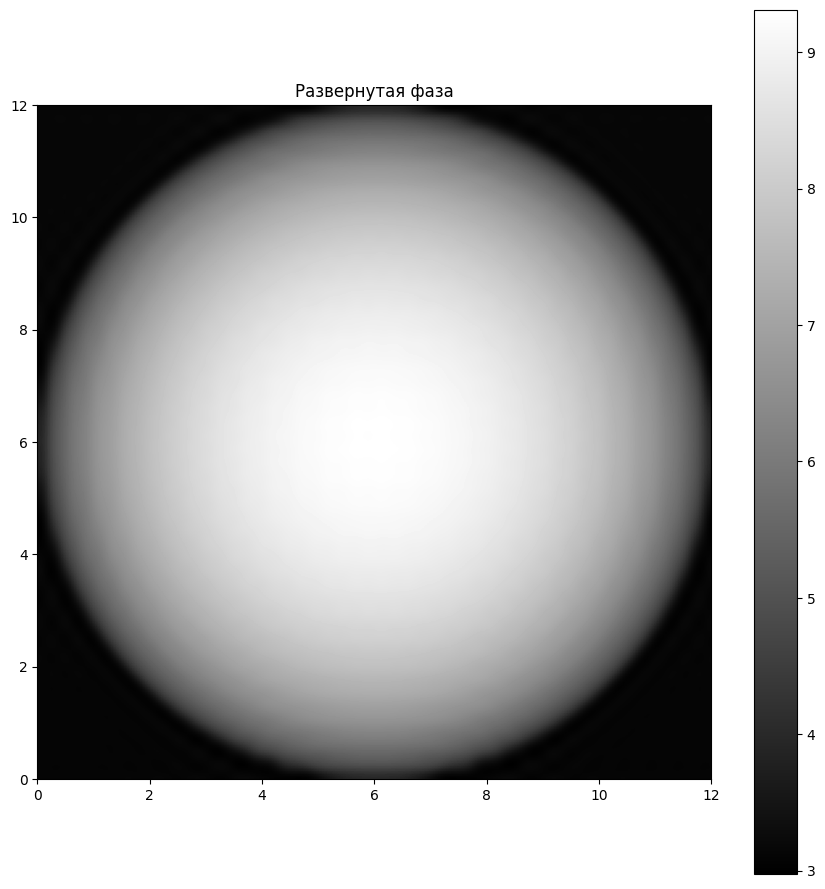

In [17]:
fig, ax = plt.subplots(figsize=(9, 9))
ax = plt.imshow(phase_unwraped, cmap='gray', extent=[tx.min(), tx.max(), ty.min(), ty.max()])
plt.colorbar();
plt.title('Развернутая фаза')
fig.tight_layout()
# plt.savefig('Фаза.jpeg', dpi=500)

In [18]:
OPD = phase_unwraped * lamda0 / (2 * np.pi)
OPD = OPD - np.min(OPD)

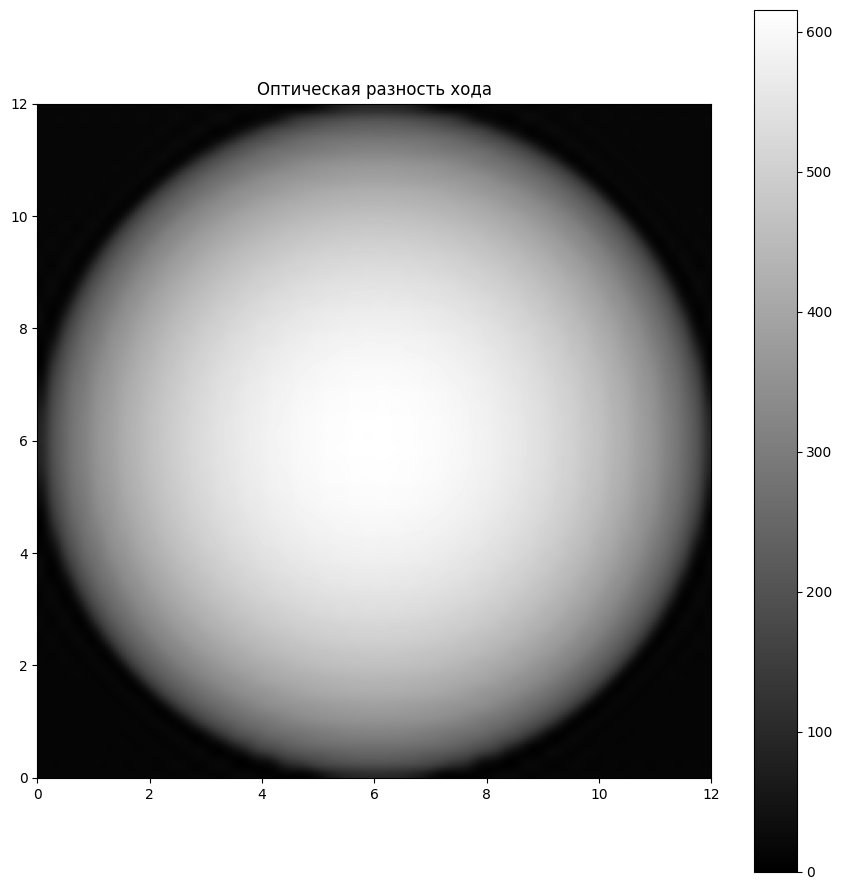

In [19]:
fig, ax = plt.subplots(figsize=(9, 9))
ax = plt.imshow(OPD, cmap='gray', extent=[tx.min(), tx.max(), ty.min(), ty.max()])
plt.colorbar();
plt.title('Оптическая разность хода')
fig.tight_layout()
# plt.savefig('OPD тепловая карта.jpeg', dpi=500)

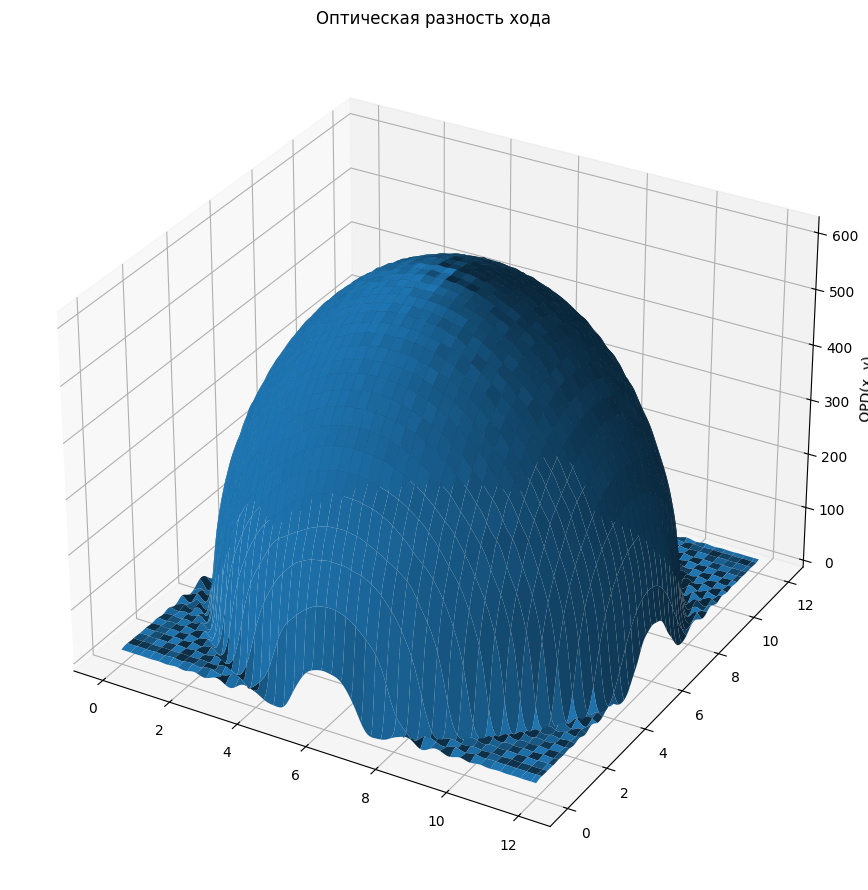

In [20]:
X, Y = np.meshgrid(tx, ty)
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection='3d'))
ax.plot_surface(X, Y, OPD)
ax.set_zlabel('OPD(x, y)')
ax.set_title('Оптическая разность хода')
fig.tight_layout()
# plt.savefig('OPD.jpeg', dpi=500)